In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch import nn, Tensor
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

In [3]:
class LSTM(nn.Module):

    def __init__(self, num_output, num_features,
                 hidden_size, num_layers):
        ## hidden_size is like embedding feature space dimension
        ## better > num_assets?
        ## if num_layers = 2: stack 2 LSTM of lyaer 1:
        # nn.Sequential(OrderedDict([
        #     ('LSTM1', nn.LSTM(input_size, hidden_size, 1),
        #     ('LSTM2', nn.LSTM(hidden_size, hidden_size, 1)
        #     ]))
        super(LSTM, self).__init__()
        self.num_output = num_output
        self.num_layers = num_layers
        self.num_features = num_features
        self.hidden_size = hidden_size
        # self.window_size = window_size

        self.lstm = nn.LSTM(input_size=num_features, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(p=0.2)
        self.fc = nn.Linear(hidden_size, num_output)

    def forward(self, x):
        # print(x.shape)
        batch_size = x.shape[0]
        # the second dim for h_0 and c_0 is the batch dim
        # hidden state
        h_0 = Variable(torch.zeros(
            self.num_layers, batch_size, self.hidden_size), requires_grad=True)
        # cell state
        c_0 = Variable(torch.zeros(
            self.num_layers, batch_size, self.hidden_size), requires_grad=True)

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        # get only the last hidden layer, needed for multiple layer
        h_out = h_out[-1,:,:].view(-1, self.hidden_size)

        out = self.fc(self.dropout(h_out))

        return out


In [4]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        # patience: num of times allowed for new_loss > old_loss+delta
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [5]:
import pandas as pd
from pipeline import Dataset, backtest
from matplotlib import pyplot as plt
from datatools import data_quantization, check_dataframe, extract_market_data
from sklearn.model_selection import TimeSeriesSplit
from tqdm.auto import tqdm, trange
from pandas import Series, DataFrame, MultiIndex
from visualization.metric import Performance
from sklearn.metrics import r2_score
from visualization.metric import plot_performance
from sklearn.preprocessing import MinMaxScaler


In [6]:
dataset = Dataset.load('../../data/parsed')
# dataset = load_mini_dataset('../../data/parsed_mini/')

In [7]:
quantized_fundamental, _ = data_quantization(dataset.fundamental)
df = pd.concat([quantized_fundamental, dataset.fundamental, dataset.ref_return], axis=1).dropna()
quantile_feature = ['turnoverRatio_QUANTILE', 'transactionAmount_QUANTILE', 'pb_QUANTILE', 'ps_QUANTILE',
                            'pe_ttm_QUANTILE', 'pe_QUANTILE', 'pcf_QUANTILE']
original_feature = ['turnoverRatio', 'transactionAmount', 'pb', 'ps', 'pe_ttm', 'pe', 'pcf']

check_dataframe(df, expect_index=['day','asset'])


In [8]:
df['return_known'] = df['return'].shift(2*54)
df=df.dropna()

In [130]:
original_feature = ['turnoverRatio', 'transactionAmount', 'pb', 'ps', 'pe_ttm', 'pe', 'pcf','return_known']
quantile_feature = ['turnoverRatio_QUANTILE', 'transactionAmount_QUANTILE', 'pb_QUANTILE', 'ps_QUANTILE',
                            'pe_ttm_QUANTILE', 'pe_QUANTILE', 'pcf_QUANTILE', 'return_known']

## Training only use the current data (one data one training each fold)

In [9]:
# Hyperparameter
n_splits = 995
n_epoch = 3
learning_rate = 0.01
lookback_window = 8
# Define loss
# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
# Define feature
original_feature = ['turnoverRatio', 'transactionAmount', 'pb', 'ps', 'pe_ttm', 'pe', 'pcf','return_known']
feature_columns = original_feature
return_column = ['return']
num_features = len(feature_columns)

# Define network
net = LSTM(num_output=1, #only the return
           num_features=num_features,
             hidden_size=1024, num_layers=1)

# Define the optimizier
# optimizer = optim.LBFGS(net.parameters(), lr=learning_rate)
optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9, 0.999))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 100, gamma = 0.5)

train_loss_list = []
# label_train_list = []
val_loss_list = []
# test_score_old = 0
days = df.index.get_level_values('day').unique()
tscv = TimeSeriesSplit(n_splits=min(n_splits, len(days)))

scaler = MinMaxScaler()
early_stopper = EarlyStopper(patience=3, min_delta=10)

for epoch in range(n_epoch):

    torch.manual_seed(3407)
    pbar = tqdm(tscv.split(days), total=tscv.n_splits)

    cum_y_val_true = Series(dtype=float)
    cum_y_val_prediction = Series(dtype=float)
    performance = Performance()
    # feature_columns = quantile_feature
    train_loss = 0
    val_loss = 0
    # np.random.seed(44)
    # for epoch in range(n_epoch):
    for fold, (train, val) in enumerate(pbar):
        # X, _ = data_quantization(df[original_feature])
        running_loss = 0
        days_train = days[train]

        if len(days_train) < 2:
            print('Skipping this fold since we cannot truncate the last day.')
            continue
        # if (lookback_window is not None) and (len(days_train) > lookback_window):
        if fold > 200:
            cum_y_train_true = Series(dtype=float)
            cum_y_train_prediction = Series(dtype=float)

            days_train_valid = days_train[-lookback_window-1:-1] # last ends at valid-day-2
            X_train, y_train_true = df.loc[(days_train_valid,), :][feature_columns], df.loc[(days_train_valid[-1]),:][return_column]

            X_np = X_train.swaplevel(1,0).sort_index(ascending=True).to_numpy().astype(np.float32)
            X_np = scaler.fit_transform(X_np)
            # X_np_tensor = X_np.reshape(54,lookback_window,-1).transpose([2,1,0])
            X_np_tensor = X_np.reshape(54,lookback_window,-1)
            # shape (asset, days, feature)  LSTM Shape: (batch(first), seq_len, feature)
            # X_np_tensor = X_np_tensor[np.newaxis,:]  # add batch dimension
            X_torch = torch.from_numpy(X_np_tensor)
            labels = torch.tensor(y_train_true['return'].values).to(torch.float)#
            def closure():
                optimizer.zero_grad()
                outputs=net(X_torch)
                loss = criterion(outputs, labels)
                loss.backward()
                return loss
            net.train()
            optimizer.zero_grad()
            outputs = net(X_torch)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            # optimizer.step(closure) # need closure for LBFGS
            optimizer.step()

            scheduler.step() ### !!!!!
            cum_y_train_prediction = pd.concat([cum_y_train_prediction, Series(outputs.detach().numpy().squeeze())])
            cum_y_train_true = pd.concat([cum_y_train_true, y_train_true.squeeze()], ignore_index=True)

            performance[fold,'train_r2'] = r2_score(cum_y_train_prediction, cum_y_train_true)
            if fold % 100 == 0:
                print('Fold [{}/{}], Loss: {:.4f}, cum_train_r2: {:.2f}%'.format(fold, len(pbar), loss.item(), r2_score(cum_y_train_prediction, cum_y_train_true)))
            # loss_list.append(loss.item())
            train_loss+=loss.item()

            # Validation:
            days_val = days[int(val)-lookback_window:int(val)]

            X_val, y_val_true = df.loc[(days_val,), :][feature_columns], df.loc[(days_val[-1],), :][return_column]
            net.eval()
            with torch.no_grad():
                X_np_val = X_val.swaplevel(1,0).sort_index(ascending=True).to_numpy().astype(np.float32)
                X_np_val = scaler.fit_transform(X_np_val)
                # shape (asset, days, feature) -> (ft, days, asset)
                X_np_val_tensor = X_np_val.reshape(54,lookback_window,-1)
                # X_np_val_tensor = X_np_val_tensor[np.newaxis,:]  # add batch dimension
                X_torch_val = torch.from_numpy(X_np_val_tensor)
                labels_val = torch.tensor(y_val_true['return'].values).to(torch.float)

                outputs_val = net(X_torch_val)
                loss_val = criterion(outputs_val.squeeze(), labels_val)
                val_loss+=loss_val.item()

                cum_y_val_prediction = pd.concat([cum_y_val_prediction, Series(outputs_val.numpy().squeeze())])
                cum_y_val_true = pd.concat([cum_y_val_true, y_val_true.squeeze()], ignore_index=True)

            val_r2 = r2_score(y_val_true.squeeze(), Series(outputs_val.numpy().squeeze())) # Do I need index for series to corr or R2?
            performance[fold, 'val_r2'] = val_r2
            val_pearson = y_val_true.squeeze().corr(Series(outputs_val.numpy().squeeze()))
            performance[fold, 'val_pearson'] = val_pearson
            val_cum_r2 = r2_score(cum_y_val_true, cum_y_val_prediction)
            performance[fold, 'val_cum_r2'] = val_cum_r2
            val_cum_pearson = cum_y_val_true.corr(cum_y_val_prediction)
            performance[fold, 'val_cum_pearson'] = val_cum_pearson

            pbar.set_description(f'Fold {fold}, val_cum_r2={val_cum_r2:.4f}, val_cum_pearson={val_cum_pearson:.4f}')

        else:
            pass

    epoch_train_loss = train_loss/fold
    epoch_val_loss =  val_loss/fold
    train_loss_list.append(epoch_train_loss)
    val_loss_list.append(epoch_val_loss)
    if early_stopper.early_stop(epoch_val_loss):
      print("We stop at epoch:", epoch)
      break
        # if fold > 20:
        #     break
        # X_train, y_train_true = df.loc[(days_train_valid,), :][feature_columns], df.loc[(days_train_valid,), :][return_column]
        # X_val, y_val_true = df.loc[(days_val,), :][feature_columns], df.loc[(days_val,), :][return_column]

  0%|          | 0/995 [00:00<?, ?it/s]

Skipping this fold since we cannot truncate the last day.
Fold [300/995], Loss: 0.0554, cum_train_r2: -1.00%
Fold [400/995], Loss: 0.0207, cum_train_r2: -0.40%
Fold [500/995], Loss: 0.0113, cum_train_r2: -0.01%
Fold [600/995], Loss: 0.0057, cum_train_r2: -0.15%
Fold [700/995], Loss: 0.0059, cum_train_r2: -0.14%
Fold [800/995], Loss: 0.0056, cum_train_r2: -0.32%
Fold [900/995], Loss: 0.0052, cum_train_r2: 0.05%


  0%|          | 0/995 [00:00<?, ?it/s]

Skipping this fold since we cannot truncate the last day.
Fold [300/995], Loss: 0.0053, cum_train_r2: 0.06%
Fold [400/995], Loss: 0.0065, cum_train_r2: -0.20%
Fold [500/995], Loss: 0.0061, cum_train_r2: 0.01%
Fold [600/995], Loss: 0.0041, cum_train_r2: -0.21%
Fold [700/995], Loss: 0.0049, cum_train_r2: -0.12%
Fold [800/995], Loss: 0.0053, cum_train_r2: -0.39%
Fold [900/995], Loss: 0.0049, cum_train_r2: 0.05%


  0%|          | 0/995 [00:00<?, ?it/s]

Skipping this fold since we cannot truncate the last day.
Fold [300/995], Loss: 0.0051, cum_train_r2: 0.07%
Fold [400/995], Loss: 0.0063, cum_train_r2: -0.20%
Fold [500/995], Loss: 0.0061, cum_train_r2: 0.01%
Fold [600/995], Loss: 0.0041, cum_train_r2: -0.21%
Fold [700/995], Loss: 0.0049, cum_train_r2: -0.13%
Fold [800/995], Loss: 0.0053, cum_train_r2: -0.38%
Fold [900/995], Loss: 0.0049, cum_train_r2: 0.05%


In [22]:
test = Series(outputs.detach().numpy().squeeze())

In [64]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

print(get_lr(optimizer))

1.862645149230957e-11


The ending score for metric train_r2 is: -7.9770e+01
The ending score for metric val_cum_r2 is: -7.2764e-03
The ending score for metric val_cum_pearson is: 3.9519e-02


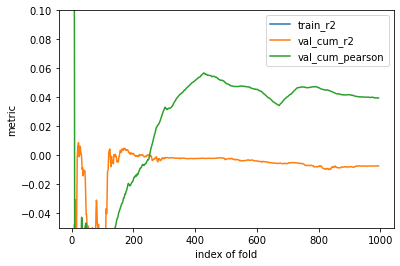

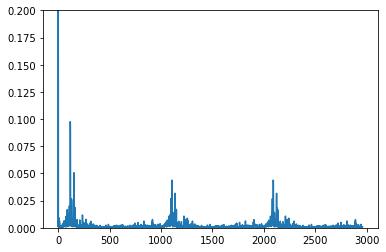

In [28]:
# lr step=100; nepoch=3; lookback=8; lr start=0.05, end=1e-11
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson','val_cum_r2'])

plt.figure(1)
plt.plot(loss_list)
plt.ylim([0,0.2])
plt.show()

The ending score for metric train_r2 is: -2.2526e+01
The ending score for metric val_cum_r2 is: -1.0788e+00
The ending score for metric val_cum_pearson is: -1.3687e-04


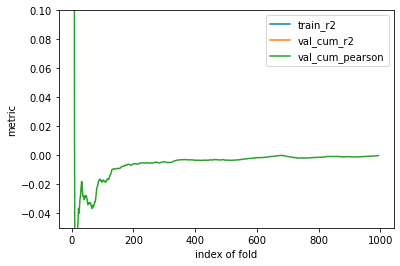

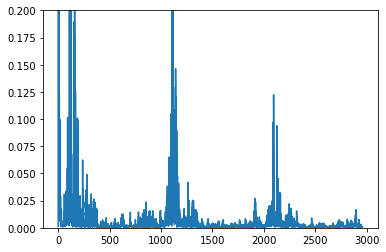

In [31]:
# lr step=500; nepoch=3; lookback=8; lr 0.1, end=0.003
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson','val_cum_r2'])

plt.figure(1)
plt.plot(loss_list)
plt.ylim([0,0.2])
plt.show()

The ending score for metric train_r2 is: -4.2967e+02
The ending score for metric val_cum_r2 is: -4.2305e-02
The ending score for metric val_cum_pearson is: 1.0187e-02


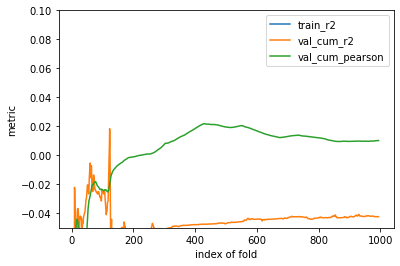

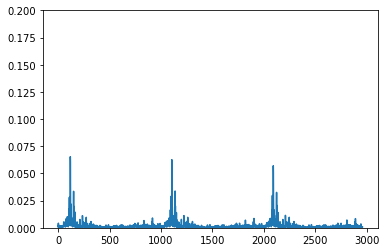

In [34]:
# no lr step; nepoch=3; lookback=8; lr start=1e-4
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson','val_cum_r2'])

plt.figure(1)
plt.plot(loss_list)
plt.ylim([0,0.2])
plt.show()

The ending score for metric train_r2 is: -8.1909e+00
The ending score for metric val_cum_r2 is: -3.8061e-02
The ending score for metric val_cum_pearson is: 2.0547e-02


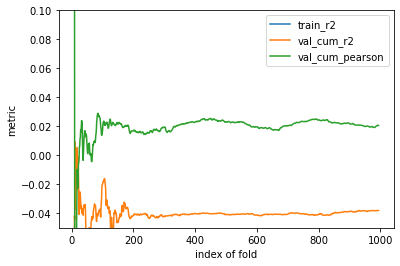

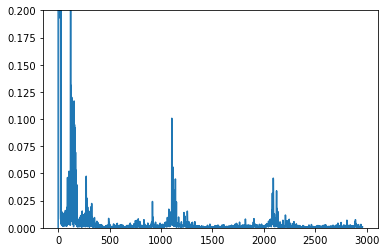

In [41]:
# lr step=200; nepoch=3; lookback=8; lr start=0.1 end=6e-6; hidden_size=512
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson','val_cum_r2'])

plt.figure(1)
plt.plot(loss_list)
plt.ylim([0,0.2])
plt.show()

In [ ]:
# lr step=200; nepoch=100; lookback=8; lr start=5e-5
# Doesn't work

In [ ]:
# lr step=200; nepoch=3; lookback=8; lr start=0.1 end=6e-6, 2 layers
# but val r2 seems to decay nicely; a bit slow
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson','val_cum_r2'])

plt.figure(1)
plt.plot(loss_list)
plt.ylim([0,0.2])
plt.show()

The ending score for metric train_r2 is: 0.0000e+00
The ending score for metric val_cum_r2 is: -3.2609e-06


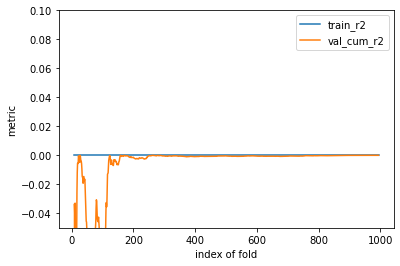

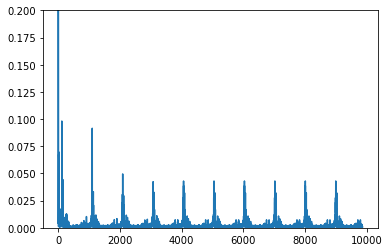

In [17]:
# lr step=300; nepoch=10; lookback=8; lr start=0.1 end=6e-6, 2 layers, 128 hidden
# doesn't work
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_r2'])

plt.figure(1)
plt.plot(loss_list)
plt.ylim([0,0.2])
plt.show()

The ending score for metric train_r2 is: -7.0970e+02
The ending score for metric val_cum_r2 is: -2.8990e-03
The ending score for metric val_cum_pearson is: -5.5838e-02


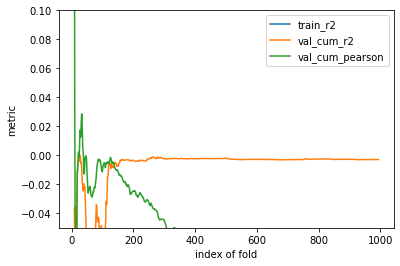

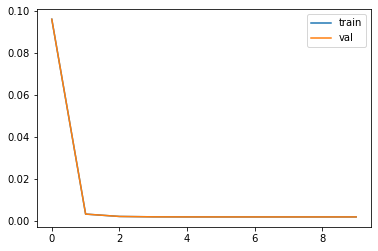

In [31]:
# lr step=300; nepoch=10; lookback=8; lr start=0.1 end=2e-11, 1 layers, 128 hidden
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_r2', 'val_cum_pearson'])

plt.figure(1)
plt.plot(range(n_epoch), train_loss_list, range(n_epoch),val_loss_list)
# plt.ylim([0,0.2])
plt.legend(['train', 'val'])
plt.show()

The ending score for metric train_r2 is: -6.9504e+02
The ending score for metric val_cum_r2 is: -2.5562e-02
The ending score for metric val_cum_pearson is: -4.7640e-04


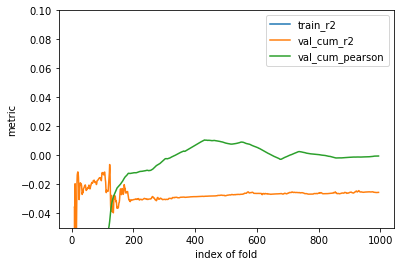

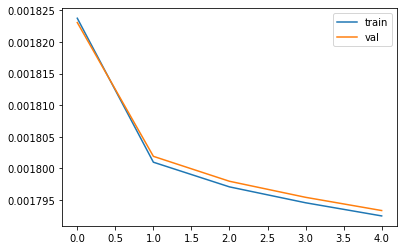

In [33]:
# no lr step; nepoch=5; lookback=8; lr 5e-5, 1 layers, 128 hidden
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_r2', 'val_cum_pearson'])

plt.figure(1)
plt.plot(range(n_epoch), train_loss_list, range(n_epoch),val_loss_list)
# plt.ylim([0,0.2])
plt.legend(['train', 'val'])
plt.show()

The ending score for metric train_r2 is: -4.4243e+03
The ending score for metric val_cum_r2 is: 6.1596e-04
The ending score for metric val_cum_pearson is: 4.9299e-02


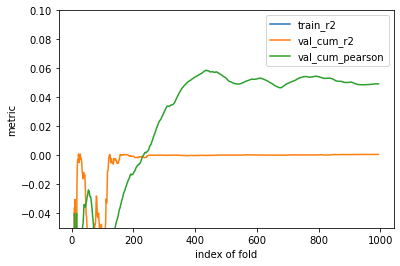

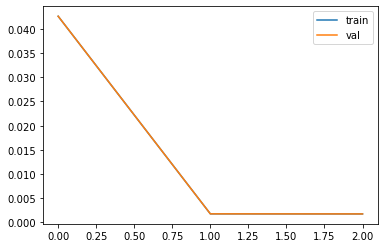

In [43]:
#lr step=100; nepoch=3; lookback=8; lr start 0.05, end 1e-11 1 layers, 128 hidden
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_r2', 'val_cum_pearson'])

plt.figure(1)
plt.plot(range(n_epoch), train_loss_list, range(n_epoch),val_loss_list)
# plt.ylim([0,0.1])
plt.legend(['train', 'val'])
plt.show()

The ending score for metric train_r2 is: -7.1154e+03
The ending score for metric val_cum_r2 is: -4.4610e-05
The ending score for metric val_cum_pearson is: 3.7067e-02


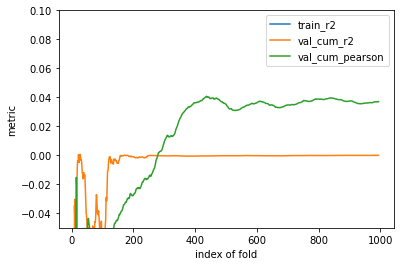

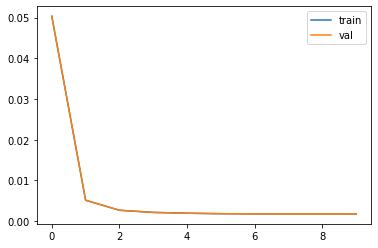

In [46]:
# lr step=500; nepoch=10; lookback=8; lr start 0.05, end 1e-11 1 layers, 128 hidden
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_r2', 'val_cum_pearson'])

plt.figure(1)
plt.plot(range(n_epoch), train_loss_list, range(n_epoch),val_loss_list)
# plt.ylim([0,0.1])
plt.legend(['train', 'val'])
plt.show()

The ending score for metric train_r2 is: -3.7192e+02
The ending score for metric val_cum_r2 is: -1.1226e-03
The ending score for metric val_cum_pearson is: 4.5148e-02


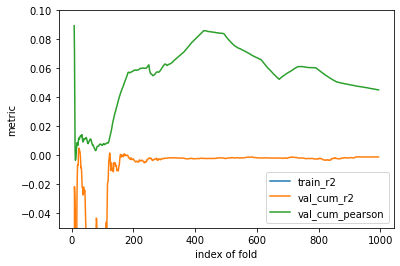

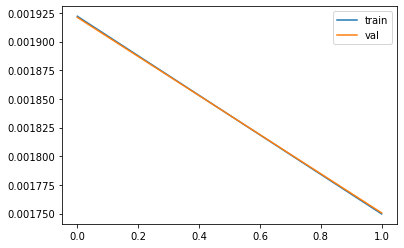

In [54]:
# lr step=100; nepoch=2; lookback=8; lr start 0.005, end 1e-9 1 layers, 128 hidden
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_r2', 'val_cum_pearson'])

plt.figure(1)
plt.plot(range(n_epoch), train_loss_list, range(n_epoch),val_loss_list)
# plt.ylim([0,0.1])
plt.legend(['train', 'val'])
plt.show()


The ending score for metric train_r2 is: -2.0893e+02
The ending score for metric val_cum_r2 is: -1.8870e-03
The ending score for metric val_cum_pearson is: 2.9132e-02


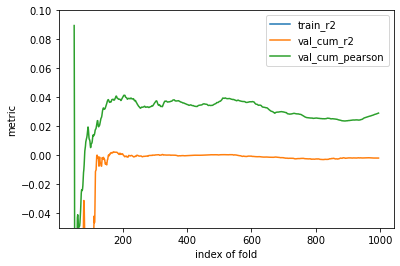

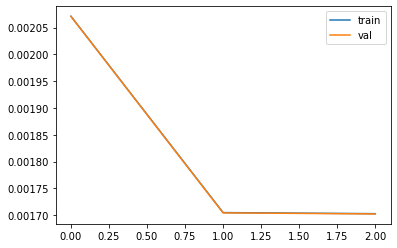

In [57]:
# lr step=100; nepoch=3; lookback=50; lr start 0.01, end 3e-11 1 layers, 128 hidden
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_r2', 'val_cum_pearson'])

plt.figure(1)
plt.plot(range(n_epoch), train_loss_list, range(n_epoch),val_loss_list)
# plt.ylim([0,0.1])
plt.legend(['train', 'val'])
plt.show()

The ending score for metric train_r2 is: -8.2779e+01
The ending score for metric val_cum_r2 is: -2.2277e-02
The ending score for metric val_cum_pearson is: -4.3475e-03


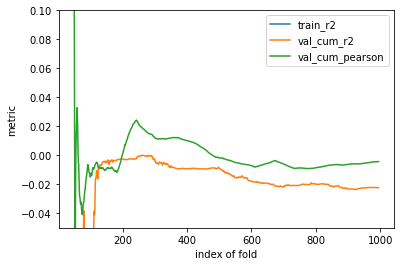

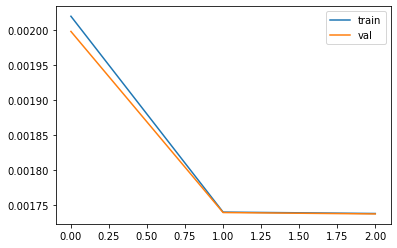

In [59]:
# lr step=100; nepoch=3; lookback=50; lr start 0.01, end 3e-11 1 layers, 32 hidden
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_r2', 'val_cum_pearson'])

plt.figure(1)
plt.plot(range(n_epoch), train_loss_list, range(n_epoch),val_loss_list)
# plt.ylim([0,0.1])
plt.legend(['train', 'val'])
plt.show()



The ending score for metric train_r2 is: -2.1151e+01
The ending score for metric val_cum_r2 is: -5.1776e-02
The ending score for metric val_cum_pearson is: 1.6845e-01


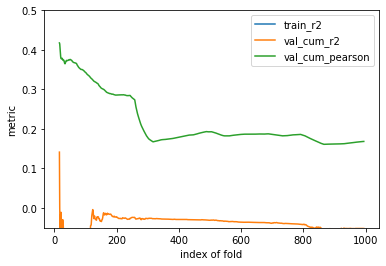

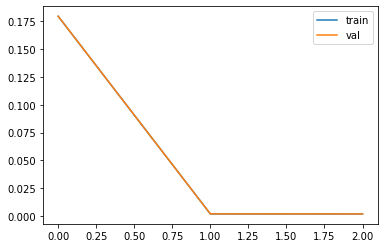

In [63]:
# lr step=100; nepoch=3; lookback=16; lr start 0.01, end 3e-11 1 layers, 1024 hidden
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_r2', 'val_cum_pearson'])

plt.figure(1)
plt.plot(range(n_epoch), train_loss_list, range(n_epoch),val_loss_list)
# plt.ylim([0,0.1])
plt.legend(['train', 'val'])
plt.show()

### Large hidden state is beneficial!


The ending score for metric train_r2 is: -1.8323e+06
The ending score for metric val_cum_r2 is: -9.8525e-04
The ending score for metric val_cum_pearson is: -6.9078e-03


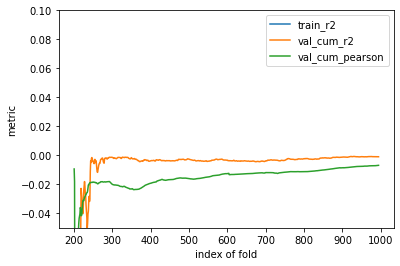

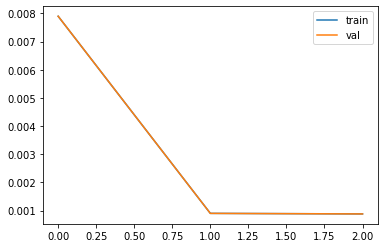

In [67]:
# lr step=100; nepoch=3; lookback=16; lr start 0.01, end 3e-11 1 layers, 256 hidden
# CV after 200
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_r2', 'val_cum_pearson'])

plt.figure(1)
plt.plot(range(n_epoch), train_loss_list, range(n_epoch),val_loss_list)
# plt.ylim([0,0.1])
plt.legend(['train', 'val'])
plt.show()

The ending score for metric train_r2 is: -3.8005e+01
The ending score for metric val_cum_r2 is: -2.9535e-02
The ending score for metric val_cum_pearson is: -2.2460e-02


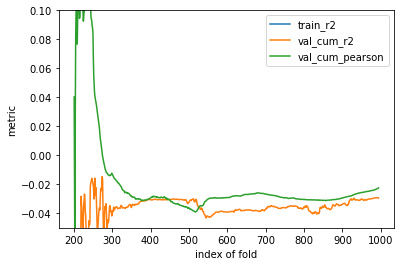

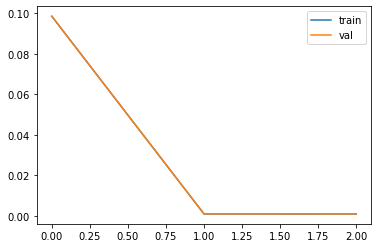

In [70]:
# lr step=100; nepoch=3; lookback=8; lr start 0.05, end 3e-11 1 layers, 256 hidden
# CV after 200 # previously worked data
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_r2', 'val_cum_pearson'])

plt.figure(1)
plt.plot(range(n_epoch), train_loss_list, range(n_epoch),val_loss_list)
# plt.ylim([0,0.1])
plt.legend(['train', 'val'])
plt.show()

The ending score for metric train_r2 is: -2.4986e-01
The ending score for metric val_cum_r2 is: -9.6968e-04
The ending score for metric val_cum_pearson is: 8.5034e-04


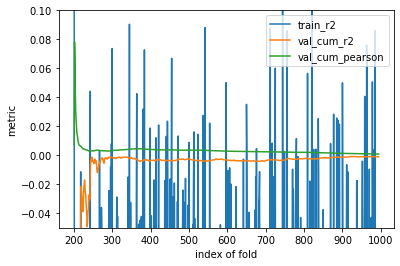

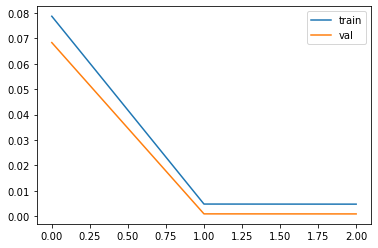

In [10]:
# lr step=100; nepoch=3; lookback=16; lr start 0.01, end 3e-11 1 layers, 1024 hidden
# Best case CV after 200
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_r2', 'val_cum_pearson'])

plt.figure(1)
plt.plot(range(n_epoch), train_loss_list, range(n_epoch),val_loss_list)
# plt.ylim([0,0.1])
plt.legend(['train', 'val'])
plt.show()

In [68]:
model_path = '../../model/dump/LSTM_1for54'
torch.save(net.state_dict(), model_path)



## Try one model for one prediction

In [11]:
class LSTM(nn.Module):

    def __init__(self, num_output, num_features,
                 hidden_size, num_layers, is_cuda: bool = False):
        ## hidden_size is like embedding feature space dimension
        ## better > num_assets?
        ## if num_layers = 2: stack 2 LSTM of lyaer 1:
        # nn.Sequential(OrderedDict([
        #     ('LSTM1', nn.LSTM(input_size, hidden_size, 1),
        #     ('LSTM2', nn.LSTM(hidden_size, hidden_size, 1)
        #     ]))
        super(LSTM, self).__init__()
        self.num_output = num_output
        self.num_layers = num_layers
        self.num_features = num_features
        self.hidden_size = hidden_size
        # self.window_size = window_size

        self.lstm = nn.LSTM(input_size=num_features, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(p=0.2)
        self.fc = nn.Linear(hidden_size, num_output)

        self.is_cuda = is_cuda

        if is_cuda:
            self.lstm.cuda()
            self.dropout.cuda()
            self.fc.cuda()

    def forward(self, x: torch.Tensor):
        # print(x.shape)
        batch_size = x.shape[0]
        # the second dim for h_0 and c_0 is the batch dim
        # hidden state
        h_0 = Variable(torch.zeros(
            self.num_layers, batch_size, self.hidden_size), requires_grad=True)
        # cell state
        c_0 = Variable(torch.zeros(
            self.num_layers, batch_size, self.hidden_size), requires_grad=True)

        if self.is_cuda:
            h_0 = h_0.cuda()
            c_0 = c_0.cuda()

        # print(x.device)
        # print(list(x.device for x in self.lstm.parameters()))
        # print(h_0.device)

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        # get only the last hidden layer, needed for multiple layer
        h_out = h_out[-1, :, :].view(-1, self.hidden_size)

        out = self.fc(self.dropout(h_out))

        return out

In [12]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        # patience: num of times allowed for new_loss > old_loss+delta
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
print(get_lr(optimizer))

In [13]:
dataset = Dataset.load('../../data/parsed')

In [154]:
quantized_fundamental, _ = data_quantization(dataset.fundamental)
df = pd.concat([quantized_fundamental, dataset.fundamental, dataset.ref_return], axis=1).dropna()
quantile_feature = ['turnoverRatio_QUANTILE', 'transactionAmount_QUANTILE', 'pb_QUANTILE', 'ps_QUANTILE',
                            'pe_ttm_QUANTILE', 'pe_QUANTILE', 'pcf_QUANTILE']
original_feature = ['turnoverRatio', 'transactionAmount', 'pb', 'ps', 'pe_ttm', 'pe', 'pcf']

check_dataframe(df, expect_index=['day','asset'], shutup=False)

m_df = extract_market_data(dataset.market)
df = pd.concat([dataset.fundamental, m_df, dataset.ref_return], axis=1).dropna()

Indices matched
Features matched
DataFame is all good for the tests


In [23]:
df['return_known'] = df['return'].shift(2*54)
df=df.dropna()



In [126]:

class NN_wrapper():
    def __init__(self, lr=0.001, criterion=nn.MSELoss(), n_epoch=100, n_feature=7, train_lookback=32, eval_lookback=16,
                 n_asset=54, gamma=0.93, hidden_size=512):
        self.net = LSTM(num_output=1, num_features=n_feature, hidden_size=hidden_size, num_layers=1, is_cuda=False)
        self.n_epoch = n_epoch
        self.criterion = criterion
        self.train_lookback = train_lookback
        self.eval_lookback = eval_lookback
        self.n_asset = n_asset

        # Define the optimizier
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr, betas=(0.9, 0.999))
        self.gamma = gamma
        self.scheduler = optim.lr_scheduler.CyclicLR(self.optimizer, base_lr=lr/10, max_lr=lr, step_size_up=n_epoch//2, cycle_momentum=False)

        self.scaler = MinMaxScaler()
        # self.early_stopper = EarlyStopper(patience=3, min_delta=10)

    def fit_predict(self, X: DataFrame, y):
        self.net.train()
        # X_transformed = self.preprocess.fit_transform(X)
        # X starts from 200
        # y starts from 215 (X_start+lookback-1)
        # X_transformed = X.query("asset==0").swaplevel(1, 0).sort_index(ascending=True)
        # y_transformed = y.to_frame().query("asset==0").swaplevel(1,0).sort_index(ascending=True).squeeze()
        X_transformed = X.swaplevel(1, 0).sort_index(ascending=True)
        y_transformed = y.swaplevel(1,0).sort_index(ascending=True).squeeze()

        # print(y_transformed)
        # print(X_transformed.head(10))
        # X.loc[idx[:]]

        X_np = X_transformed.to_numpy().astype(np.float32)
        X_np = self.scaler.fit_transform(X_np)

        X_ult_list = []
        y_ult_list = []

        for i in range(self.train_lookback):
            X_np_day = X_np[i * self.n_asset:(i + self.eval_lookback) * self.n_asset, :]
            # shape (asset, days, feature)
            X_np_tensor = X_np_day.reshape(self.n_asset, self.eval_lookback, -1)
            X_ult_list.append(torch.from_numpy(X_np_tensor))
            y_ult_list.append(torch.tensor(y_transformed[i * self.n_asset:(i + 1) * self.n_asset].values).to(torch.float))
        # stack and transform: shape (asset*observation, time_length, feature)
        # LSTM shape (batch, seq_length, feature)
        y_ult = torch.cat(y_ult_list)
        X_ult = torch.cat(X_ult_list)

        for epoch in range(self.n_epoch):
            # print('its actually training')
            def closure():
                self.optimizer.zero_grad()
                outputs = self.net(X_ult)
                loss = self.criterion(outputs, y_ult)
                loss.backward()
                return loss

            self.optimizer.zero_grad()
            outputs = self.net(X_ult).squeeze()
            loss = self.criterion(outputs, y_ult)
            # print(loss)
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            # print(self.scheduler.get_last_lr())

        return outputs.cpu().detach().numpy()

    def predict(self, X):
        self.net.eval()
        # X_transformed = self.preprocess.fit_transform(X)
        X_transformed = X.query("asset==0").swaplevel(1, 0).sort_index(ascending=True)

        X_np = X_transformed.to_numpy().astype(np.float32)
        X_np = self.scaler.transform(X_np)
        # shape (asset, days, feature) -> (ft, days, asset)
        X_np_tensor = X_np.reshape(self.n_asset, self.eval_lookback, -1)
        # X_np_tensor = X_np_tensor[np.newaxis, :]  # add batch dimension
        X_torch = torch.from_numpy(X_np_tensor)
        y = self.net(X_torch)
        # return np.clip(y.detach().numpy(), -0.2, 0.2)
        return np.clip(y.cpu().squeeze().detach().numpy(), -0.2,0.2)

Validation on day 799, train_r2=0.7237, val_r2=nan, val_cum_r2=-1.5657, val_cum_pearson=-0.0180: 100%|██████████| 576/576 [01:12<00:00,  7.94it/s] 


In [167]:
from pipeline.backtest import cross_validation

# feature = ['turnoverRatio', 'transactionAmount', 'pb', 'ps', 'pe_ttm', 'pe', 'pcf']
feature = ['avg_price', 'volatility', 'mean_volume', 'return_0', 'pe','pcf','pb']
# df_train = df[feature]
train_lookback = 16
eval_lookback = 8
model = NN_wrapper(lr=1e-3, n_epoch=6, hidden_size=256, n_feature=len(feature),
                   train_lookback=train_lookback, eval_lookback=eval_lookback, n_asset=1)
idx = pd.IndexSlice
performance, cum_y_df = cross_validation(model, feature, df.loc[idx[200:, :], :], train_lookback=train_lookback, per_eval_lookback=eval_lookback)



Validation on day 799, train_r2=0.5159, val_r2=nan, val_cum_r2=-1.3670, val_cum_pearson=-0.0021: 100%|██████████| 576/576 [00:32<00:00, 17.87it/s] 


The ending score for metric train_r2 is: 5.1591e-01
The ending score for metric val_cum_r2 is: -1.3670e+00
The ending score for metric val_cum_pearson is: -2.1028e-03


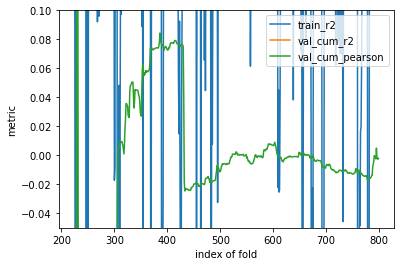

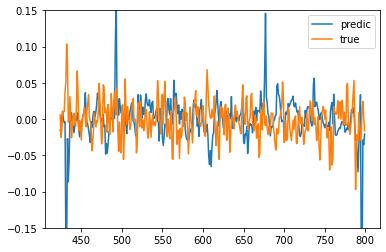

In [168]:
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_r2', 'val_cum_pearson'])
#
plt.figure(1)
val_predict = cum_y_df['cum_y_val_prediction'].to_numpy()
val_true = cum_y_df['cum_y_val_true'].to_numpy()
x = np.arange(len(val_predict))+200+train_lookback+eval_lookback
plt.plot(x[200:800],val_predict[200:800], x[200:800],val_true[200:800])
plt.ylim([-0.15,0.15])
plt.legend(['predic', 'true'])
plt.show()

The ending score for metric train_r2 is: 8.5008e-01
The ending score for metric val_cum_r2 is: -2.1777e+00
The ending score for metric val_cum_pearson is: -1.0055e-01


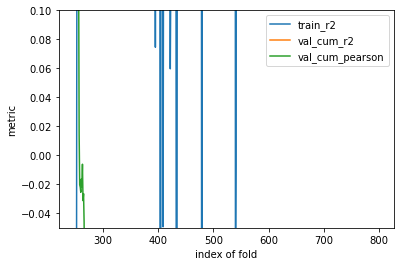

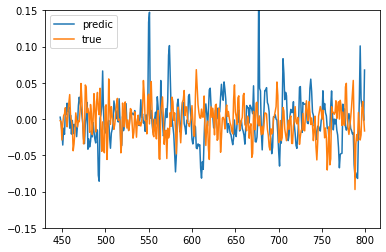

In [163]:
plt.figure(0)
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_r2', 'val_cum_pearson'])
#
plt.figure(1)
val_predict = cum_y_df['cum_y_val_prediction'].to_numpy()
val_true = cum_y_df['cum_y_val_true'].to_numpy()
x = np.arange(len(val_predict))+200+train_lookback+eval_lookback
plt.plot(x[200:800],val_predict[200:800], x[200:800],val_true[200:800])
plt.ylim([-0.15,0.15])
plt.legend(['predic', 'true'])
plt.show()

In [169]:
save_1 = val_true[200:800]

In [164]:
save_2 = val_true[200:800]

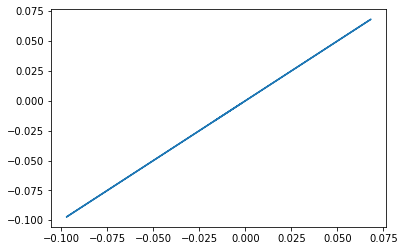

In [171]:
plt.plot(save_1[24:], save_2)

In [77]:
model_path = '../../model/dump/LSTM_1for54_noreturn'
torch.save(net.state_dict(), model_path)

In [15]:
# define input sequence
in_seq1 = np.array([x for x in range(0,100,10)])
in_seq2 = np.array([x for x in range(5,105,10)])
out_seq = np.array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])

In [16]:
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

In [17]:
# horizontally stack columns
test = np.hstack((in_seq1, in_seq2, out_seq))

The ending score for metric train_r2 is: -7.6914e+05
The ending score for metric val_cum_r2 is: -3.1575e-04
The ending score for metric val_cum_pearson is: 1.8511e-02


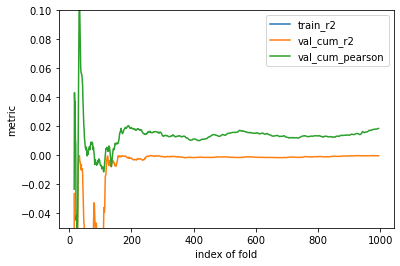

In [36]:
plt.figure()
# plot_performance(performance, metrics_selected=['train_r2', 'test_cum_r2', 'test_cum_pearson'])
plot_performance(performance, metrics_selected=['train_r2', 'val_cum_pearson','val_cum_r2'])
plt.show()

In [34]:
performance

In [219]:
model_path = '../../model/dump/1DConv'
torch.save(net.state_dict(), model_path)


In [24]:
df.head(10)

turnoverRatio_QUANTILE  transactionAmount_QUANTILE  \
day asset                                                       
1   0                           9                           9   
    1                           9                           3   
    2                           7                           4   
    3                           8                           2   
    4                           5                           4   
    5                           7                           3   
    6                           9                          10   
    7                           6                           4   
    8                           8                           5   
    9                          10                           9   

           pe_ttm_QUANTILE  pe_QUANTILE  pb_QUANTILE  ps_QUANTILE  \
day asset                                                           
1   0                    6            6            6            5   
    1                    4            4            6            5   
    2                    7            7            6            6   
    3                    1            1            2            1   
    4                    1            1            3            4   
    5                    9            9           10           10   
    6                   10            1            1            1   
    7                    4            4            9           10   
    8                    6            5           10            7   
    9                    2            1            3            1   

           pcf_QUANTILE  turnoverRatio  transactionAmount    pe_ttm        pe  \
day asset                                                                       
1   0                 1         3.6794            17229.0   34.4425   32.3029   
    1                 5         2.5150             3706.0   28.9934   27.2726   
    2                 3         1.2858             5136.0   42.9352   41.9279   
    3                 7         2.2007             3280.0   15.2245   13.8032   
    4                 4         0.8627             5291.0 -369.9850 -433.1736   
    5                 2         1.4799             3602.0   79.2510   98.2418   
    6                 4         3.1936            50013.0  230.3588  -84.8581   
    7                 1         1.1519             5420.0   28.0377   27.6825   
    8                 7         1.9779             5518.0   33.4061   29.6512   
    9                 3         4.9000            18490.0   16.5951   14.7185   

                pb       ps       pcf    return  
day asset                                        
1   0       4.9425   3.8180 -578.7700 -0.026877  
    1       5.0552   3.0484   23.8260 -0.052674  
    2       4.8083   4.1392  -58.2185 -0.002691  
    3       2.1904   0.6691   61.0491 -0.018515  
    4       3.0714   2.9370  -25.2279 -0.019184  
    5      10.4734  16.9784 -220.7509  0.024430  
    6       1.6212   0.6232    9.5680  0.018743  
    7       7.9503  10.4892 -236.7706  0.014376  
    8      11.1719   4.8248   58.7035 -0.011925  
    9       3.0420   0.7481  -46.2671 -0.020020

In [32]:
X_transformed = df.query("asset==0").swaplevel(1,0)
X_transformed.head(10)

turnoverRatio_QUANTILE  transactionAmount_QUANTILE  \
asset day                                                       
0     1                         9                           9   
      2                         9                           9   
      3                         9                           8   
      4                        10                          10   
      5                        10                          10   
      6                        10                          10   
      7                        10                          10   
      8                        10                          10   
      9                        10                          10   
      10                       10                           9   

           pe_ttm_QUANTILE  pe_QUANTILE  pb_QUANTILE  ps_QUANTILE  \
asset day                                                           
0     1                  6            6            6            5   
      2                  6            5            6            5   
      3                  3            3            6            4   
      4                  3            3            6            5   
      5                  4            4            6            5   
      6                  3            4            6            5   
      7                  3            4            6            5   
      8                  3            4            6            5   
      9                  3            4            6            5   
      10                 3            4            6            5   

           pcf_QUANTILE  turnoverRatio  transactionAmount   pe_ttm       pe  \
asset day                                                                     
0     1               1         3.6794            17229.0  34.4425  32.3029   
      2               1         3.2535            18378.0  33.3198  31.2498   
      3               3         2.4947            13686.0  23.3887  23.3887   
      4               3         4.5625            22587.0  23.9187  23.9187   
      5               3        18.2257            65239.0  25.9119  25.9119   
      6               3         9.5071            34200.0  25.5778  25.5778   
      7               3         5.6046            23782.0  25.2091  25.2091   
      8               3         6.4456            29299.0  24.9441  24.9441   
      9               3         4.6144            23753.0  25.4050  25.4050   
      10              3         4.2888            17827.0  25.3474  25.3474   

               pb      ps       pcf    return  
asset day                                      
0     1    4.9425  3.8180 -578.7700 -0.026877  
      2    4.7814  3.6935 -559.9031  0.028805  
      3    4.3823  2.9722  -42.8676  0.107928  
      4    4.4816  3.0396  -43.8390  0.068998  
      5    4.8551  3.2929  -47.4923 -0.027238  
      6    4.7925  3.2504  -46.8799 -0.024789  
      7    4.7234  3.2036  -46.2041  0.008067  
      8    4.6737  3.1699  -45.7184  0.016307  
      9    4.7601  3.2284  -46.5631 -0.013184  
      10   4.7493  3.2211  -46.4575  0.010385

In [33]:
X_np = X_transformed.to_numpy().astype(np.float32)
print(X_np)

[[ 9.0000000e+00  9.0000000e+00  6.0000000e+00 ...  3.8180001e+00
  -5.7877002e+02 -2.6876958e-02]
 [ 9.0000000e+00  9.0000000e+00  6.0000000e+00 ...  3.6935000e+00
  -5.5990308e+02  2.8805364e-02]
 [ 9.0000000e+00  8.0000000e+00  3.0000000e+00 ...  2.9721999e+00
  -4.2867599e+01  1.0792758e-01]
 ...
 [ 8.0000000e+00  7.0000000e+00  9.0000000e+00 ...  1.5208000e+00
  -4.0244400e+01  3.9919834e-03]
 [ 7.0000000e+00  8.0000000e+00  9.0000000e+00 ...  1.5447000e+00
  -4.0875000e+01 -2.3551574e-02]
 [ 8.0000000e+00  8.0000000e+00  9.0000000e+00 ...  1.5268000e+00
  -4.0402000e+01 -1.8874254e-02]]


In [44]:
X_np_day = X_np[0:4, :]
# shape (asset, days, feature) -> (ft, days, asset)
X_np_tensor = X_np_day.reshape(1, 4, -1)
print(X_np_tensor)

[[[ 9.0000000e+00  9.0000000e+00  6.0000000e+00  6.0000000e+00
    6.0000000e+00  5.0000000e+00  1.0000000e+00  3.6794000e+00
    1.7229000e+04  3.4442501e+01  3.2302898e+01  4.9425001e+00
    3.8180001e+00 -5.7877002e+02 -2.6876958e-02]
  [ 9.0000000e+00  9.0000000e+00  6.0000000e+00  5.0000000e+00
    6.0000000e+00  5.0000000e+00  1.0000000e+00  3.2535000e+00
    1.8378000e+04  3.3319801e+01  3.1249800e+01  4.7814002e+00
    3.6935000e+00 -5.5990308e+02  2.8805364e-02]
  [ 9.0000000e+00  8.0000000e+00  3.0000000e+00  3.0000000e+00
    6.0000000e+00  4.0000000e+00  3.0000000e+00  2.4947000e+00
    1.3686000e+04  2.3388700e+01  2.3388700e+01  4.3822999e+00
    2.9721999e+00 -4.2867599e+01  1.0792758e-01]
  [ 1.0000000e+01  1.0000000e+01  3.0000000e+00  3.0000000e+00
    6.0000000e+00  5.0000000e+00  3.0000000e+00  4.5625000e+00
    2.2587000e+04  2.3918699e+01  2.3918699e+01  4.4815998e+00
    3.0395999e+00 -4.3839001e+01  6.8998188e-02]]]


In [41]:
X_list = []

In [45]:
X_list.append(torch.from_numpy(X_np_tensor))

In [46]:
X_ult_list = torch.cat(X_list)
X_ult_list.shape


torch.Size([2, 4, 15])

In [55]:
x=np.arange(4)
x[0:3]
x[2:3]

array([2])

In [65]:
y = df['return']
y.head()

day  asset
1    0       -0.026877
     1       -0.052674
     2       -0.002691
     3       -0.018515
     4       -0.019184
Name: return, dtype: float64

In [70]:
y_df = y.to_frame()
y_df.query('asset==0')

,,return
day,asset,
1,0,-0.026877
2,0,0.028805
3,0,0.107928
4,0,0.068998
5,0,-0.027238
...,...,...
994,0,-0.026212
995,0,-0.000985
996,0,0.003992


In [72]:
y_series = y_df.query('asset==0').squeeze()
y_series.head()

day  asset
1    0       -0.026877
2    0        0.028805
3    0        0.107928
4    0        0.068998
5    0       -0.027238
Name: return, dtype: float64

In [151]:
df.columns


Index(['turnoverRatio', 'transactionAmount', 'pe_ttm', 'pe', 'pb', 'ps', 'pcf',
       'avg_price', 'volatility', 'mean_volume', 'return_0'],
      dtype='object')